In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
import numpy as np

In [2]:
##Backgrounds grouped into three.
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
     ]
TT = [ 
    "TTJets",
     ]

bgs= QCD + DY + TT

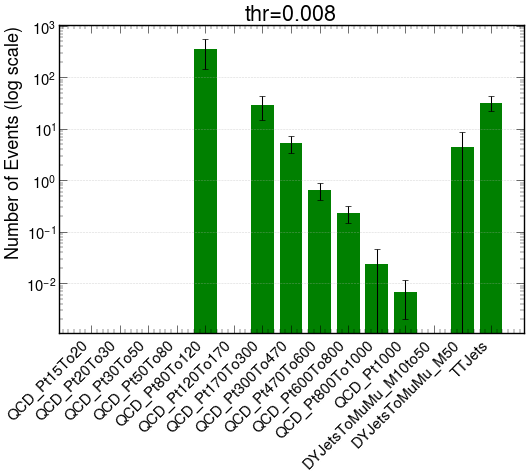

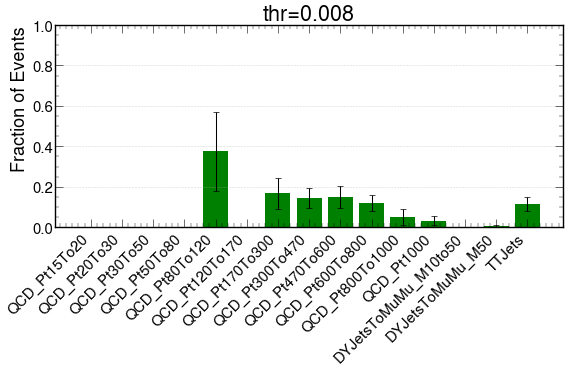

['QCD_Pt15To20', 'QCD_Pt20To30', 'QCD_Pt30To50', 'QCD_Pt50To80', 'QCD_Pt80To120', 'QCD_Pt120To170', 'QCD_Pt170To300', 'QCD_Pt300To470', 'QCD_Pt470To600', 'QCD_Pt600To800', 'QCD_Pt800To1000', 'QCD_Pt1000']
QCD_Pt15To20
QCD_Pt20To30
QCD_Pt30To50
QCD_Pt50To80
QCD_Pt80To120
QCD_Pt120To170
QCD_Pt170To300
QCD_Pt300To470
QCD_Pt470To600
QCD_Pt600To800
QCD_Pt800To1000
QCD_Pt1000
['TTJets']
TTJets
['DYJetsToMuMu_M10to50', 'DYJetsToMuMu_M50']
DYJetsToMuMu_M10to50
DYJetsToMuMu_M50


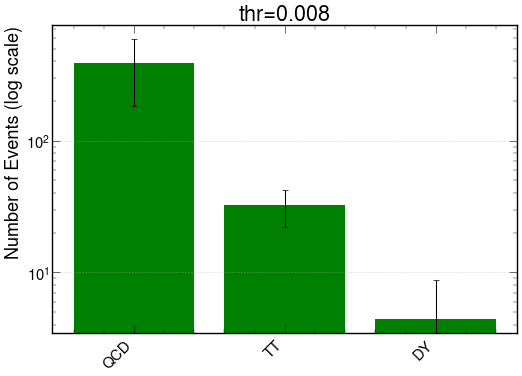

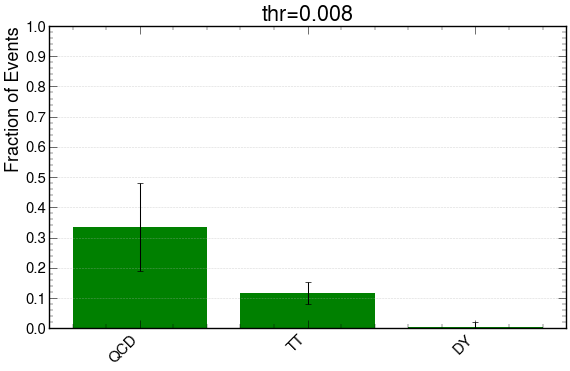

In [3]:
histogram_name = "mu_lj_pfMuon_min_dxy_XLowRange"
channel_name = "base_ljObjCut_ljIso_2lj"


##compute_histgram_stats
def compute_histogram_stats(histogram, threhold):
    values = histogram.values()
    variances = histogram.variances()
    overflow = histogram.values(flow =True)[-1]
    overflow_var = histogram.variances(flow =True)[-1]
    underflow = histogram.values(flow =True)[0]
    underflow_var = histogram.variances(flow =True)[0]
    bin_edges = histogram.axes[0].edges
    idx = np.searchsorted(bin_edges, threshold, side="right") -1
    idx = max(idx, 0)
    n_pass = values[idx:].sum() + overflow.sum()
    sigma_pass = np.sqrt(variances[idx:].sum() + overflow_var.sum())
    n_total = values.sum() + overflow + underflow
    sigma_total = np.sqrt(variances.sum() + overflow_var + underflow_var)
    fraction = n_pass / n_total if n_total > 0 else 0

    if n_total > 0 and n_pass > 0:
        num_counts_arr = np.array([n_pass**2 / sigma_pass**2])
        denom_counts_arr = np.array([n_total**2 / sigma_total**2])
        fraction_err = intervals.ratio_uncertainty(
        num_counts_arr,
        denom_counts_arr,
        uncertainty_type='efficiency')[0][0]
    else:
        fraction_err = 0
    return n_pass, n_total, sigma_pass, sigma_total, fraction, fraction_err
def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, ::4j]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist
threshold = 0.008
background_pass = {}
background_pass_err = {}
background_total = {}
background_total_err = {}
background_fraction = {}
background_fraction_err = {}

for bg in bgs:
    filename = f"output_{bg}{channel_name}.coffea"
    output_bg=coffea.util.load(filename)
    histogram = output_bg["out"][bg]["hists"][histogram_name][channel_name, :]
    n_pass, n_total, sigma_pass, sigma_total,fraction, fraction_err = compute_histogram_stats(histogram, threshold)
    background_pass[bg]= n_pass
    background_pass_err[bg]= sigma_pass
    background_total[bg]= n_total
    background_total_err[bg]= sigma_total
    background_fraction[bg] = fraction
    background_fraction_err[bg] = fraction_err


yields = np.array([background_pass[s] for s in bgs])
fractions = np.array([background_fraction[s] for s in bgs])
yerr_yields = np.array([background_pass_err[s] for s in bgs])
yerr_fractions = np.array([background_fraction_err[s] for s in bgs])

plt.figure(figsize=(12, 8))
plt.bar(bgs, yields, yerr=yerr_yields, color='green', capsize=5)
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Events (log scale)")
plt.title(f"thr={threshold}")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)


plt.figure(figsize=(12, 8))
plt.bar(bgs, fractions, yerr=yerr_fractions, color='green', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.2))
plt.ylabel("Fraction of Events")
plt.title(f"thr={threshold}")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


bg_groups = ["QCD", "TT", "DY"]
background_pass_group = {}
background_pass_err_group = {}
background_total_group = {}
background_total_err_group = {}
background_fraction_group = {}
background_fraction_err_group = {}
for bg in bg_groups:
    bg_sub = globals()[bg] 
    print(bg_sub)
    sum_bg = sum_bgs_hist(bg_sub, histogram_name, channel_name)
    n_pass, n_total, sigma_pass, sigma_total,fraction, fraction_err = compute_histogram_stats(sum_bg, threshold)
    background_pass_group[bg]= n_pass
    background_pass_err_group[bg]= sigma_pass
    background_total_group[bg]= n_total
    background_total_group[bg]= sigma_total
    background_fraction_group[bg] = fraction
    background_fraction_err_group[bg] = fraction_err


yields = np.array([background_pass_group[s] for s in bg_groups])
fractions = np.array([background_fraction_group[s] for s in bg_groups])
yerr_yields = np.array([background_pass_err_group[s] for s in bg_groups])
yerr_fractions = np.array([background_fraction_err_group[s] for s in bg_groups])

plt.figure(figsize=(12, 8))
plt.bar(bg_groups, yields, yerr=yerr_yields, color='green', capsize=5)
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Events (log scale)")
plt.title(f"thr={threshold}")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)


plt.figure(figsize=(12, 8))
plt.bar(bg_groups, fractions, yerr=yerr_fractions, color='green', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.ylabel("Fraction of Events")
plt.title(f"thr={threshold}")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
    
    
    


In [4]:
filename = f"output_QCD_Pt80To120{channel_name}.coffea"
output_bg=coffea.util.load(filename)
# histogram = output_bg["out"]["]["hists"][histogram_name][channel_name, :]
output_bg["out"]["QCD_Pt80To120"]["cutflow"][channel_name].print_table(unweighted=True)

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection             641772.0     641772.0
pass triggers             55573.0      55573.0
PV filter                641772.0      55573.0
>=1 egm_ljs               16090.0        100.0
>=1 mu_ljs                 5161.0          8.0
